# DATASET_BUILDING_FOR_SCENARIO_1
---
**10.05.2019**

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime
import pickle
import ast
import time
import heartpy as hp
import matplotlib
import matplotlib.pyplot as plt
from biosppy import storage
from biosppy.signals import ecg
import neurokit as nk
%matplotlib inline

/home/skalskip/Documents/REPOS/ImaBoss/.env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## 2. Settings

In [2]:
# BITALINO

BITALINO_COLUMNS_TO_USE = [5, 6]
BITALINO_COLUMN_NAMES = [
    "EKG", 
    "GSR"
]
BITALINO_SAMPLING_RATE_PER_SEC = 1000

# PROCEDURE

PROCEDURE_COLUMNS_TO_USE = [2, 3, 4, 5, 6, 7, 8, 9]
PROCEDURE_COLUMN_NAMES = [
    "CONDITION",
    "SPEC_CONDITION",
    "SOUND_NUM",
    "IMAGE_NUM",
    "WIDGET_TYPE",
    "WIDGET_RESPONSE",
    "RESPONSE_TIME",
    "TIMESTAMP"
]

# FILE MAP

FILE_MAP_NAME = "file_map"

## 3. Loading of general data

In [3]:
IAPS_data = pd.read_csv("./data/IAPS.csv",sep=";")
IADS2_data = pd.read_csv("./data/IADS2.csv",sep=";")
NEOFFI_data = pd.read_csv("./data/NEO-FFI.txt",sep="\t")

## 4. General data preprocessing

### 4.1. IPAS

In [4]:
def preprocess_IAPS(data):
# Convert to int and if it fails, delete the row
    data['IAPS'] = pd.to_numeric(data['IAPS'], errors='coerce')
    data = data.dropna(subset=['IAPS'])
    data['IAPS'] = data['IAPS'].astype('int')

    data['ValenceMean'] = data['ValenceMean'].apply(lambda x: x.replace(',','.')).astype(float)
    data['ValenceSD'] = data['ValenceSD'].apply(lambda x: x.replace(',','.')).astype(float)
    data['ArousalMean'] = data['ArousalMean'].apply(lambda x: x.replace(',','.')).astype(float)
    data['ArousalSD'] = data['ArousalSD'].apply(lambda x: x.replace(',','.')).astype(float)
    return data.drop(["Description", "set"], axis=1)

In [5]:
IPAS = preprocess_IAPS(IAPS_data)

/home/skalskip/Documents/REPOS/ImaBoss/.env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/skalskip/Documents/REPOS/ImaBoss/.env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/skalskip/Documents/REPOS/ImaBoss/.env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [6]:
IPAS.head()

,IAPS,ValenceMean,ValenceSD,ArousalMean,ArousalSD
0,1019,3.95,1.96,5.77,1.83
1,1022,4.26,2.04,6.02,1.97
2,1026,4.09,1.91,5.61,2.23
3,1030,4.30,2.35,5.46,2.43
4,1033,3.87,1.94,6.13,2.15


In [7]:
IPAS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1171 entries, 0 to 1193
Data columns (total 5 columns):
IAPS           1171 non-null int64
ValenceMean    1171 non-null float64
ValenceSD      1171 non-null float64
ArousalMean    1171 non-null float64
ArousalSD      1171 non-null float64
dtypes: float64(4), int64(1)
memory usage: 54.9 KB


### 4.2. IADS2

In [8]:
def preprocess_IADS2(data):
    return data.drop(["Sound"], axis=1)

In [9]:
IADS2 = preprocess_IADS2(IADS2_data)

In [10]:
IADS2.head()

,Number,ValenceMean,ValenceSD,ArousalMean,ArousalSD
0,102,4.63,2.17,4.91,1.97
1,104,4.96,1.68,5.37,1.66
2,105,2.88,2.14,6.40,2.13
3,106,3.37,1.64,6.39,1.62
4,107,5.47,2.22,5.85,1.81


In [11]:
IADS2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 5 columns):
Number         167 non-null int64
ValenceMean    167 non-null float64
ValenceSD      167 non-null float64
ArousalMean    167 non-null float64
ArousalSD      167 non-null float64
dtypes: float64(4), int64(1)
memory usage: 6.6 KB


### 4.3. Personality questionnaire results

In [12]:
def preprocess_NEOFFI(data):
    data["SEX"] = data["SEX"].apply(lambda x: x=="M").astype(int)
    return data

In [13]:
NEOFFI = preprocess_NEOFFI(NEOFFI_data)

In [14]:
NEOFFI.head()

,ID,AGE,SEX,OTW,SUM,NEU,UGD,EKST
0,1107,21,0,4,6,3,4,10
1,1153,22,0,5,3,8,3,8
2,1233,21,0,6,8,2,10,7
3,1400,22,1,4,6,6,6,5
4,1402,27,0,9,7,7,4,7


In [15]:
NEOFFI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 8 columns):
ID      79 non-null int64
AGE     79 non-null int64
SEX     79 non-null int64
OTW     79 non-null int64
SUM     79 non-null int64
NEU     79 non-null int64
UGD     79 non-null int64
EKST    79 non-null int64
dtypes: int64(8)
memory usage: 5.0 KB


### 5. Loading of raw data

### 5.1. Auxiliary functions

In [16]:
def load_data_bitalino(file_path):
    return pd.read_csv(
        file_path,sep="\t", 
        skiprows=3, 
        usecols=BITALINO_COLUMNS_TO_USE, 
        names=BITALINO_COLUMN_NAMES, 
        header=None
    )

In [17]:
def load_data_procedure(file_path):
    return pd.read_csv(
        file_path,sep="\t", 
        usecols=PROCEDURE_COLUMNS_TO_USE, 
        names=PROCEDURE_COLUMN_NAMES, 
        header=None
    )

In [18]:
def load_file_map(file_name):
    pickle_in = open(file_name,"rb")
    dictionary = pickle.load(pickle_in)
    return dictionary

In [19]:
def extract_start_time(file_path):
    metadata_str = None
    fp = open(file_path)
    
    # meta data are on the second line of the file
    for i, line in enumerate(fp):
        if i == 1:
            metadata_str = line
            fp.close()
            break
           
    # meta data starts with '# ' and ends with a new line sign
    metadata_str = metadata_str[2 : -1]
    # the meta data format is consistent with the Python dictionary
    metadata_dict = ast.literal_eval(metadata_str)
    
    # HACK: the acquired dictionary is nested but has only one key on the first level
    key_name = list(metadata_dict)[0]
    
    time_str = metadata_dict[key_name]['time']
    date_str = metadata_dict[key_name]['date']
    datetime_str = date_str + "," + time_str
    
    return time.mktime(datetime.strptime(datetime_str, "%Y-%m-%d,%H:%M:%S.%f").timetuple())

In [20]:
def spec_condition_helper(x):
    if x=='-':
        return(0)
    elif x=='0':
        return(1)
    elif x=='+':
        return(2)

### 5.2. Load file map

In [21]:
FILE_MAP = load_file_map(FILE_MAP_NAME)

### 5.3. Preproces raw data

In [22]:
def preprocess_procedure(data):
    # select only rows concerning widgets of emoscale1 type
    data = data[data["WIDGET_TYPE"] == "emoscale1"]
    
    # convert the response time to float and if the value is not correct then remove the row
    data['RESPONSE_TIME'] = pd.to_numeric(data['RESPONSE_TIME'], errors='coerce')
    data = data.dropna(subset=['RESPONSE_TIME'])
    data['RESPONSE_TIME'] = data['RESPONSE_TIME'].astype('float')
    
    # enforcing the appropriate type of columns
    data["CONSISTENT"] = data['CONDITION'].apply(lambda x: x=="con").astype(int)
    data["IMAGE_ATTRIBUTE"] = data['SPEC_CONDITION'].apply(lambda x: spec_condition_helper(x[1])).astype(int)
    data["SOUND_ATTRIBUTE"] = data['SPEC_CONDITION'].apply(lambda x: spec_condition_helper(x[3])).astype(int)
    data["WIDGET_RESPONSE"] = data["WIDGET_RESPONSE"].astype(float).astype(int)
    data["TIMESTAMP"] = data["TIMESTAMP"].astype(int)
    
    # deleting unnecessary columns
    data.drop(["CONDITION", "SPEC_CONDITION", "WIDGET_TYPE"], axis=1, inplace=True)
    return data

In [23]:
def preprocess_bitalino(data, start_time):
    out = ecg.ecg(signal=data["EKG"], sampling_rate=1000)
    hr = out['heart_rate']
    t_end = np.floor(out['heart_rate_ts'] * 1000)
    t_start = np.insert(t_end[:-1] + 1, 0, 0, axis=0)

In [27]:
FILE_MAP.keys()

dict_keys(['9076', '8057', '6546', '6635', '9639', '9926', '3723', '3172', '2121', '4124', '3497', '9222', '1107', '6412', '4087', '5948', '3567', '1516', '3327', '7686', '9296', '8341', '8040', '2104', '2688', '3054', '9937', '5513', '6801', '8722', '4231', '4484', '9495', '8101', '4542', '2110', '1507', '3377', '8624', '7820', '3333', '1402', '2070', '4830', '7957', '9744', '2669', '8909', '2006', '6111', '2881', '4624', '6684', '9740', '6678', '7078', '7474', '5330', '6603', '3802', '5215', '1809', '5900', '3640', '4105', '5099', '7630', '9702', '2428', '7311', '8002', '2103', '5648', '9695', '9952', '1153', '2900', '8803', '5924', '7777', '3264', '1233', '5104', '1437', '1400', '8958', '3872', '9899', '7250', '8500', '7020'])

In [28]:
file_paths = FILE_MAP['7020']

In [29]:
bitalino_data = load_data_bitalino(file_paths['bitalino'])
procedure_data = load_data_procedure(file_paths['procedure'])
bitalino_start_time = extract_start_time(file_paths['bitalino'])

In [30]:
procedure_data = preprocess_procedure(procedure_data)

/home/skalskip/Documents/REPOS/ImaBoss/.env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
procedure_data.head(50)

,SOUND_NUM,IMAGE_NUM,WIDGET_RESPONSE,RESPONSE_TIME,TIMESTAMP,CONSISTENT,IMAGE_ATTRIBUTE,SOUND_ATTRIBUTE
60,817,8470,5,1.050144,1555592738,1,2,2
61,109,3261,2,0.000205,1555592755,0,0,2
62,705,2309,2,0.333498,1555592773,1,1,1
63,719,6821,1,0.800075,1555592790,1,0,0
65,310,8470,2,0.883443,1555592825,0,2,0
66,289,6263,1,1.000134,1555592843,1,0,0
67,728,2525,2,0.333472,1555592860,1,1,1
68,104,2810,2,0.350159,1555592878,1,1,1
70,420,8178,2,0.333456,1555592913,0,2,0
71,813,9423,1,0.816755,1555592930,0,0,2


In [32]:
procedure_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 60 to 119
Data columns (total 8 columns):
SOUND_NUM          52 non-null int64
IMAGE_NUM          52 non-null int64
WIDGET_RESPONSE    52 non-null int64
RESPONSE_TIME      52 non-null float64
TIMESTAMP          52 non-null int64
CONSISTENT         52 non-null int64
IMAGE_ATTRIBUTE    52 non-null int64
SOUND_ATTRIBUTE    52 non-null int64
dtypes: float64(1), int64(7)
memory usage: 3.7 KB


In [33]:
len(bitalino_data)

4364400

In [34]:
bitalino_data = preprocess_bitalino(bitalino_data, bitalino_start_time)

/home/skalskip/Documents/REPOS/ImaBoss/.env/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/skalskip/Documents/REPOS/ImaBoss/.env/lib/python3.6/site-packages/numpy/ma/core.py:5159: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/home/skalskip/Documents/REPOS/ImaBoss/.env/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/skalskip/Documents/REPOS/ImaBoss/.env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/skalskip/Documents/REPOS/Im

4360
4360


In [35]:
bitalino_data.head()

,HR,GSR,TIMESTAMP
0,78.513478,0.0,1.555591e+09
1,74.441687,0.0,1.555591e+09
2,73.152890,0.0,1.555591e+09
3,72.797865,0.0,1.555591e+09
4,72.815534,0.0,1.555591e+09


In [36]:
bitalino_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4360 entries, 0 to 4359
Data columns (total 3 columns):
HR           4326 non-null float64
GSR          4360 non-null float64
TIMESTAMP    4360 non-null float64
dtypes: float64(3)
memory usage: 102.3 KB


In [37]:
bitalino_data[bitalino_data["TIMESTAMP"] == 1555593279 - 1]

,HR,GSR,TIMESTAMP
2608,259.179266,501.211,1.555593e+09


In [38]:
bitalino_data[bitalino_data["TIMESTAMP"] == 1555593279]

,HR,GSR,TIMESTAMP
2609,73.385519,504.747,1.555593e+09


In [39]:
bitalino_data[bitalino_data["TIMESTAMP"] == 1555593279 + 1]

,HR,GSR,TIMESTAMP
2610,73.242188,504.934,1.555593e+09


In [40]:
bitalino_data[bitalino_data["TIMESTAMP"] == 1555593279 + 2]

,HR,GSR,TIMESTAMP
2611,72.098053,503.878,1.555593e+09


In [41]:
bitalino_data[bitalino_data["TIMESTAMP"] == 1555593699 + 10]

,HR,GSR,TIMESTAMP
3039,261.295591,492.479,1.555594e+09


In [42]:
bitalino_data[bitalino_data["TIMESTAMP"] == 1555593699 + 15]

,HR,GSR,TIMESTAMP
3044,135.013501,485.115,1.555594e+09


In [43]:
file_paths['bitalino']

'./data/raw_data/bitalino/7020_opensignals_lewestanowisko_2019-04-18_14-31-02.txt'

In [119]:
bitalino_data = load_data_bitalino(file_paths['bitalino'])
bitalino_start_time = extract_start_time(file_paths['bitalino'])

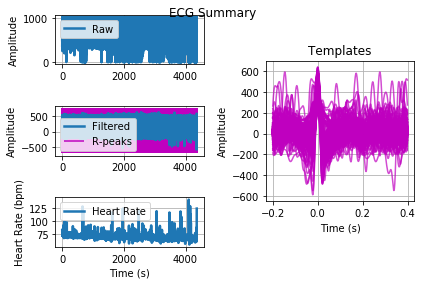

In [45]:
out = ecg.ecg(signal=bitalino_data["EKG"], sampling_rate=1000., show=True)

In [46]:
out.keys()

['ts',
 'filtered',
 'rpeaks',
 'templates_ts',
 'templates',
 'heart_rate_ts',
 'heart_rate']

In [100]:
np.floor(out['heart_rate_ts'] * 1000)

array([1.061000e+03, 1.809000e+03, 2.542000e+03, ..., 4.362388e+06,
       4.363051e+06, 4.363709e+06])

In [101]:
hr = out['heart_rate']
t_end = np.floor(out['heart_rate_ts'] * 1000)

In [102]:
t_start = np.insert(t_end[:-1] + 1, 0, 0, axis=0)

In [103]:
data = pd.DataFrame({'T_START': t_start, 'T_END': t_end, 'HR': hr}, columns=['T_START', 'T_END', 'HR'])

In [109]:
data['T_START'] = data['T_START'].astype('int')

In [110]:
data['T_END'] = data['T_END'].astype('int')

In [111]:
data.head()

,T_START,T_END,HR
0,0,1061,82.996758
1,1062,1809,82.152493
2,1810,2542,79.180330
3,2543,3337,76.365807
4,3338,4173,72.527337


In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5026 entries, 0 to 5025
Data columns (total 3 columns):
T_START    5026 non-null int64
T_END      5026 non-null int64
HR         5026 non-null float64
dtypes: float64(1), int64(2)
memory usage: 117.9 KB


In [115]:
data['GSR'] = data.apply(lambda row: row['T_START']+row['T_END'], axis=1)

In [116]:
data

,T_START,T_END,HR,GSR
0,0,1061,82.996758,1061.0
1,1062,1809,82.152493,2871.0
2,1810,2542,79.180330,4352.0
3,2543,3337,76.365807,5880.0
4,3338,4173,72.527337,7511.0
5,4174,5026,72.000646,9200.0
6,5027,5838,72.860348,10865.0
7,5839,6645,73.983714,12484.0
8,6646,7459,73.248035,14105.0
9,7460,8296,73.156245,15756.0


In [117]:
data['GSR'] = data.apply(lambda row: bitalino_data.iloc[int(row['T_START']):int(row['T_END'])]["GSR"].mean(), axis=1)

In [120]:
data["TIMESTAMP"] = bitalino_start_time + data["T_START"]

In [121]:
data.head()

,T_START,T_END,HR,GSR,TIMESTAMP
0,0,1061,82.996758,0.0,1.555591e+09
1,1062,1809,82.152493,0.0,1.555592e+09
2,1810,2542,79.180330,0.0,1.555592e+09
3,2543,3337,76.365807,0.0,1.555593e+09
4,3338,4173,72.527337,0.0,1.555594e+09
